In [1]:
using CSV
using DataFrames
using Optim
using Distributions
using LinearAlgebra  
using Plots
using SymPy

In [2]:
# Load Data 
particle_data = CSV.read("particles.csv", DataFrame)

Row,shower,pdg,kinetic_energy,x,y,z,time,weight
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,22,2.68063,-2511.15,5536.2,0.0,1.13973e-5,1.0
2,0,22,1.16594,-1897.83,3594.58,0.0,1.55407e-5,1.0
3,0,22,1.69784,-1689.12,3238.18,0.0,1.28297e-5,1.0
4,0,22,8.22074,-1520.27,2680.62,0.0,1.60523e-5,1.0
5,0,22,1.2727,-1450.41,2461.66,0.0,1.68368e-5,1.0
6,0,22,1.35689,-2470.07,5260.24,0.0,5.77628e-6,1.0
7,0,22,1.16295,-2714.79,5966.96,0.0,7.03563e-6,1.0
8,0,22,1.04626,-2740.38,6047.79,0.0,7.90808e-6,1.0
9,0,22,6.21258,-1973.2,4061.56,0.0,1.15843e-5,1.0


In [ ]:
#= # Function to calculate the Cartesian distance between two points in 3D space
function cartesian_distance(x1, y1, z1, x2, y2, z2)
    return sqrt((x2 - x1)^2 + (y2 - y1)^2 + (z2 - z1)^2)
end

x1, y1, z1 = 5.82690291372798, 2.651239329640523, -0.7696777502523529 # Coordinates of the first point
x2, y2, z2 = -1.9042410053751477, -0.7535013903260498, 0.7194652218340803  # Coordinates of the second point

# Calculate the distance
distance = cartesian_distance(x1, y1, z1, x2, y2, z2)
println("The distance between the points is: $distance")

# Calculate t0
c = 299792 # km/s
t0 = distance/c
println("The value for t0 is: $t0") =#

In [12]:
# Define the vectors and rotation matrix
normal_vector = [0.45217398524533681 -0.3661629880519191 0.81330397346148509]
x_axis = [0.0 -0.91184756344828699 -0.41052895273466672]
y_axis = [0.89192975455881607 0.18563051261662877 -0.41231374670066206]

rotation_matrix = vcat(x_axis, y_axis, normal_vector)

# Extract the columns as vectors and stack them into a matrix
coords = hcat(particle_data.x, particle_data.y, particle_data.z)

# Apply the rotation matrix
rotated_positions = inv(rotation_matrix) * transpose(coords)

# Function to calculate arithmetic mean position
function calculate_mean_position(df)
    mean_x = mean(df[1,:])
    mean_y = mean(df[2,:])
    mean_z = mean(df[3,:])
    return (x=mean_x, y=mean_y, z=mean_z)
end

# Calculate the core position as the arithmetic mean of particle positions
core_position = calculate_mean_position(rotated_positions)
println("Calculated core position: $(core_position)")

Calculated core position: (x = 2485.30829674464, y = 1867.8751468942435, z = -540.8125699123239)


In [20]:
new_z = (-normal_vector[1]*rotated_positions[1,:]-normal_vector[2]*rotated_positions[2,:])/normal_vector[3]

2171-element Vector{Float64}:
 -1251.7517847346417
  -702.9784074801104
  -641.7146527540976
  -481.14035349487875
  -419.53926941634035
 -1154.8317054911845
 -1345.761551885004
 -1368.5805492201946
  -864.5820318934467
  -844.4866459675404
 -1120.9150664692336
  -764.6459401552243
 -1097.621582562589
     ⋮
  -823.2909871386399
  -345.79119651064593
  -868.1369929103747
  -825.9530252542927
  -911.7377190569741
  -909.4108375132184
  -742.3105380616302
  -889.5489367117477
  -837.6869710578463
  -920.8803900706249
 -1047.3012092427332
  -866.0201235698407

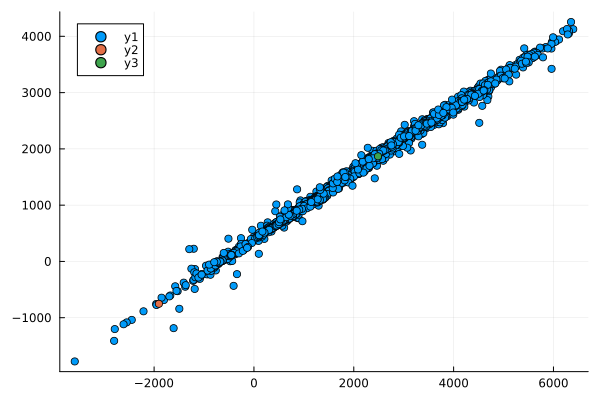

In [18]:
scatter(rotated_positions[1,:],rotated_positions[2,:])
scatter!((-1904,-753))
scatter!((2485.30829674464,1867.8751468942435))

In [21]:
rotated_positions[3,:]

2171-element Vector{Float64}:
 -1251.7517847346414
  -702.9784074801103
  -641.7146527540973
  -481.14035349487864
  -419.53926941634035
 -1154.8317054911845
 -1345.7615518850043
 -1368.5805492201944
  -864.5820318934466
  -844.4866459675401
 -1120.9150664692336
  -764.6459401552239
 -1097.6215825625886
     ⋮
  -823.2909871386397
  -345.79119651064576
  -868.1369929103745
  -825.9530252542928
  -911.737719056974
  -909.4108375132182
  -742.3105380616299
  -889.5489367117474
  -837.6869710578459
  -920.8803900706247
 -1047.3012092427332
  -866.0201235698404

In [24]:
a = 4.823e-4 / 1e9  # in s/m^2
b = 19.41 / 1e9     # in seconds (s)
sigma = 83.5  # in meters (m)
R = 125.0     # in meters (m)
c = 299792458  # Speed of light in meters per second (m/s)
t0 = 2.8612842910494837e-5  # Initial time in seconds

function delta_t()
    return a * R^2 + b * (1 - exp(-R^2 / (2 * sigma^2)))
end

initial_position = (x=5826.90291372798, y=2651.239329640523, z=-769.6777502523529)
x_pos = (x=-1904.2410053751477, y=-753.5013903260498, z=719.4652218340803)
x_c = (x=2485.30829674464, y=1867.8751468942435, z=-540.8125699123239)

zenith_rad = deg2rad(-99.99732787664736)
azimuth_rad = deg2rad(203.76835088101396)
direction_vector = (
    xdir = sin(zenith_rad) * cos(azimuth_rad),
    ydir = sin(zenith_rad) * sin(azimuth_rad),
    zdir = cos(zenith_rad)
)

function expected_signal_time(x_pos, x_c, direction_vector)
    dx = x_pos.x - x_c.x
    dy = x_pos.y - x_c.y
    dz = x_pos.z - x_c.z
    path_vector = (x=dx, y=dy, z=dz)

    dot_product = path_vector.x * direction_vector.xdir +
                  path_vector.y * direction_vector.ydir +
                  path_vector.z * direction_vector.zdir

    delta_t_val = delta_t()

    return t0 + (dot_product / c) + delta_t_val
end

expected_time = expected_signal_time(x_pos, x_c, direction_vector)
println("Expected signal time at the detector: $expected_time seconds")

Expected signal time at the detector: 1.123641044504004e-5 seconds


In [22]:
#= expected_time = expected_signal_time(t0)
println("Expected signal time: $expected_time ns") =#

# Calculate the value
delta_t_value = delta_t()

# Print the value
println("The value of delta_t is: $delta_t_value seconds")

The value of delta_t is: 2.0616097666374778e-8


In [ ]:
#= function std_dev_function(R)
    return 2.92 + 3.77e-4 * R^2  # σt(Ri) in ns
end

function likelihood_timing(particle_data, params)
    t0, xc, yc, zc, n1, n2, n3, c, a0, a1, a2 = params
    xc_vector = [xc, yc, zc]
    n_vector = [n1, n2, n3]
    log_likelihood = 0.0
    for row in eachrow(particle_data)
        x_pos = [row.x, row.y, row.z]  
        R = norm(x_pos .- xc_vector)
        sigma_t = std_dev_function(R)
        t_expected = expected_signal_time(x_pos, t0, xc_vector, n_vector, c, a0, a1, a2)
        log_likelihood += logpdf(Normal(t_expected, sigma_t), row.observed_time)
    end
    return -log_likelihood  
end =#

In [ ]:
#= particle_data = DataFrame(x = [1.0, 2.0, 3.0], y = [1.0, 2.0, 3.0], z = [1.0, 2.0, 3.0], observed_time = [10.0, 20.0, 30.0])

params = [t_0, 5.0, 5.0, 5.0, direction_vector.xdir, direction_vector.ydir, direction_vector.zdir, c, 4.823e-4, 19.41, 83.5]

log_likelihood = likelihood_timing(particle_data, params)
println("Log-likelihood: $log_likelihood") =#

In [ ]:
#= function gradient_likelihood(particle_data, params)
    gradients = zeros(length(params))
    epsilon = 1e-5
    for i in 1:length(params)
        params_eps = copy(params)
        params_eps[i] += epsilon
        grad = (likelihood_timing(particle_data, params_eps) - likelihood_timing(particle_data, params)) / epsilon
        gradients[i] = grad
    end
    return gradients
end =#

In [ ]:
#= num_epochs = 20
errors = Float64[] 

learning_rate = 0.01

for epoch in 1:num_epochs

    current_error = likelihood_timing(particle_data, params)
    
    push!(errors, current_error)
    
    println("Epoch $epoch, Error: $current_error")
    
    gradients = gradient_likelihood(particle_data, params)
    
    for i in 1:length(params)
        params[i] -= learning_rate * gradients[i]
    end
end

training_data = DataFrame(epoch = 1:num_epochs, error = errors)
 =#

In [ ]:
#= # Plot
plot(training_data.epoch, training_data.error, marker = :circle, linestyle = :solid, color = :blue, xlabel = "Epoch", ylabel = "Error", title = "Error vs. Epochs", grid = true)
 =#